<b>Сбор данных о друзьях из VK в таблицу</b>

In [ ]:
%pip install jinja2
%pip install matplotlib
%pip install networkx
%pip install openpyxl
%pip install pandas
%pip install requests
%pip install seaborn
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [53]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
from collections import deque
from IPython.display import display

In [ ]:
BASE_URL = "https://api.vk.ru/method/"
ACCESS_TOKEN = ""
API_VERSION = "5.199"

START_USER = 293108529
MAX_EDGES = 12000
MAX_FRIENDS_PER_USER = 100


def vk_request(method, params):
    params["access_token"] = ACCESS_TOKEN
    params["v"] = API_VERSION
    try:
        resp = requests.get(BASE_URL + method, params=params, timeout=10)
        data = resp.json()
        if "response" in data:
            return data["response"]
        else:
            print("VK error:", data)
            return None
    except Exception as e:
        print("Request error:", e)
        return None


def get_user_info(user_ids):
    if not user_ids:
        return {}
    ids_str = ",".join(map(str, user_ids))
    response = vk_request("users.get", {"user_ids": ids_str})
    users = {}
    if response:
        for u in response:
            users[u["id"]] = f"{u['first_name']} {u['last_name']}"
    return users


def get_friends(user_id):
    response = vk_request("friends.get", {"user_id": user_id})
    if response:
        return response["items"][:MAX_FRIENDS_PER_USER]
    return []

edges = []
visited = set()
to_visit = [START_USER]

while to_visit and len(edges) < MAX_EDGES:
    user_id = to_visit.pop(0)
    if user_id in visited:
        continue
    visited.add(user_id)

    friends = get_friends(user_id)
    user_info = get_user_info([user_id])
    friends_info = get_user_info(friends)

    for f in friends:
        if len(edges) >= MAX_EDGES:
            break
        name1 = user_info.get(user_id, "Unknown")
        name2 = friends_info.get(f, "Unknown")
        edges.append((user_id, name1, f, name2))
        to_visit.append(f)

    print(f"{user_id}: added {len(friends)} friends (total amount of relations {len(edges)})")

print(f"\nCollecting finished: {len(edges)} relations")

df = pd.DataFrame(edges, columns=["user_id_1", "name_1", "user_id_2", "name_2"])
df.insert(0, "id", range(1, len(df) + 1))
df.to_excel("vk_friends_limited.xlsx", index=False)

293108529: added 97 friends (total amount of relations 97)
VK error: {'error': {'error_code': 30, 'error_msg': 'This profile is private', 'request_params': [{'key': 'user_id', 'value': '1093805'}, {'key': 'v', 'value': '5.199'}, {'key': 'method', 'value': 'friends.get'}, {'key': 'oauth', 'value': '1'}]}}
1093805: added 0 friends (total amount of relations 97)
5372286: added 100 friends (total amount of relations 197)
VK error: {'error': {'error_code': 30, 'error_msg': 'This profile is private', 'request_params': [{'key': 'user_id', 'value': '14659428'}, {'key': 'v', 'value': '5.199'}, {'key': 'method', 'value': 'friends.get'}, {'key': 'oauth', 'value': '1'}]}}
14659428: added 0 friends (total amount of relations 197)
45210966: added 88 friends (total amount of relations 285)
51256587: added 100 friends (total amount of relations 385)
VK error: {'error': {'error_code': 30, 'error_msg': 'This profile is private', 'request_params': [{'key': 'user_id', 'value': '52300155'}, {'key': 'v', 'v

<b>Импорт данных</b>

In [18]:
df = pd.read_excel("vk_friends_limited.xlsx")

df = df[(df["name_1"] != "DELETED ") & (df["name_2"] != "DELETED ")]

print(f"Осталось записей: {len(df)}")
df.head()

Осталось записей: 11943


,id,user_id_1,name_1,user_id_2,name_2
0,1,293108529,Artyom Lisitsin,1093805,David Berov
1,2,293108529,Artyom Lisitsin,5372286,Viktoria Lobanova
2,3,293108529,Artyom Lisitsin,14659428,Irina Dolgonosova
3,4,293108529,Artyom Lisitsin,45210966,Natalya Lisitsina
4,5,293108529,Artyom Lisitsin,51256587,Alexander Gromov


In [ ]:
df.to_excel("vk_friends_clean_1.xlsx", index=False)

Выбор пользователей для исследования

In [19]:
selected_users = ["Artyom Lisitsin", "Alexander Gromov", "Litvinenko Viktor", "Andrey Klimov", "Anna Vasichkina"]

<b>Матрица смежности</b>

In [20]:
users_1 = df[['user_id_1', 'name_1']].drop_duplicates()
users_2 = df[['user_id_2', 'name_2']].drop_duplicates()

users_1.columns = ['user_id', 'name']
users_2.columns = ['user_id', 'name']

all_users_df = pd.concat([users_1, users_2]).drop_duplicates().reset_index(drop=True)
all_users = all_users_df['user_id'].values
user_to_index = {user_id: i for i, user_id in enumerate(all_users)}
index_to_name = {i: all_users_df.loc[i, 'name'] for i in range(len(all_users))}
name_to_index = {v: k for k, v in index_to_name.items()}
n = len(all_users)

A = np.zeros((n, n))
for _, row in df.iterrows():
    i = user_to_index[row['user_id_1']]
    j = user_to_index[row['user_id_2']]
    A[i, j] = 1
    A[j, i] = 1

<b>Центральность по собственному вектору</b>

In [22]:
def eigenvector_centrality(A, max_iter=1000, tol=1e-6):
    n = A.shape[0]
    x = np.ones(n)
    x = x / np.sqrt(np.sum(x**2))

    for _ in range(max_iter):
        x_new = A @ x
        x_new = x_new / np.sqrt(np.sum(x_new**2))
        if np.sqrt(np.sum((x_new - x)**2)) < tol:
            break
        x = x_new
    return x

centrality = eigenvector_centrality(A)

centrality_df = pd.DataFrame({
    'name': [index_to_name[i] for i in range(n)],
    'eigenvector_centrality': centrality
})

centrality_df = centrality_df.sort_values(by='eigenvector_centrality', ascending=False)

display(centrality_df[['name', 'eigenvector_centrality']].head(5).style.hide(axis="index"))

name,eigenvector_centrality
Galina Vasichkina,0.281044
Nikolay Lisitsyn,0.266234
Elena Lisitsyna,0.249564
Vasichkin Igor,0.234482
Natalya Lisitsyna,0.232155


Пример выборки для конкретных 5 пользователей

In [ ]:
eigen_dict = {index_to_name[i]: centrality[i] for i in range(n)}

selected_centrality = {name: eigen_dict[name] for name in selected_users if name in eigen_dict}

selected_df = pd.DataFrame({
    'name': list(selected_centrality.keys()),
    'eigenvector_centrality': list(selected_centrality.values())
}).sort_values(by='eigenvector_centrality', ascending=False)

from IPython.display import display
display(selected_df.style.hide(axis="index"))

name,eigenvector_centrality
Anna Vasichkina,0.217618
Artyom Lisitsin,0.083528
Litvinenko Viktor,0.016411
Alexander Gromov,0.001185
Andrey Klimov,0.000830


<b>Центральность по близости</b>

In [ ]:
def bfs_shortest_paths(A, start_idx):
    n = A.shape[0]
    distances = np.full(n, np.inf)
    distances[start_idx] = 0
    queue = deque([start_idx])
    
    while queue:
        current = queue.popleft()
        neighbors = np.where(A[current] > 0)[0]
        for neighbor in neighbors:
            if distances[neighbor] == np.inf:
                distances[neighbor] = distances[current] + 1
                queue.append(neighbor)
    return distances

def closeness_centrality(A):
    n = A.shape[0]
    centrality = np.zeros(n)
    
    for i in range(n):
        distances = bfs_shortest_paths(A, i)
        reachable = distances[distances < np.inf]
        if len(reachable) > 1:
            centrality[i] = ((len(reachable) - 1) / np.sum(reachable[1:])) * ((len(reachable) - 1) / (n - 1))
        else:
            centrality[i] = 0
    return centrality

closeness = closeness_centrality(A)

selected_closeness = {name: closeness[name_to_index[name]] for name in selected_users}

selected_df = pd.DataFrame({
    'name': list(selected_closeness.keys()),
    'closeness_centrality': list(selected_closeness.values())
}).sort_values(by='closeness_centrality', ascending=False)

display(selected_df.style.hide(axis="index"))

name,closeness_centrality
Artyom Lisitsin,0.366549
Litvinenko Viktor,0.271951
Andrey Klimov,0.254655
Anna Vasichkina,0.246981
Alexander Gromov,0.196429


<b>Центральность по посредничеству</b>

In [ ]:
def betweenness_centrality_selected(A, selected_indices, normalized=True):
    n = A.shape[0]
    CB = np.zeros(n)

    for s in range(n):
        S = []
        P = [[] for _ in range(n)]
        sigma = np.zeros(n)
        d = np.full(n, -1)
        sigma[s] = 1
        d[s] = 0
        Q = deque([s])

        while Q:
            v = Q.popleft()
            S.append(v)
            neighbors = np.where(A[v] > 0)[0]
            for w in neighbors:
                if d[w] < 0:
                    Q.append(w)
                    d[w] = d[v] + 1
                if d[w] == d[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v)

        delta = np.zeros(n)
        while S:
            w = S.pop()
            for v in P[w]:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])
            if w != s:
                CB[w] += delta[w]

    CB /= 2

    if normalized and n > 1:
        factor = 2 / (n * (n - 1))
        CB *= factor

    return {idx: CB[idx] for idx in selected_indices}

selected_indices = [name_to_index[name] for name in selected_users]

betweenness_selected = betweenness_centrality_selected(A, selected_indices)

betweenness_selected_df = pd.DataFrame({
    'name': selected_users,
    'betweenness_centrality': [betweenness_selected[name_to_index[name]] for name in selected_users]
}).sort_values(by='betweenness_centrality', ascending=False)

display(betweenness_selected_df.style.hide(axis="index"))

name,betweenness_centrality
Artyom Lisitsin,0.658814
Andrey Klimov,0.018904
Anna Vasichkina,0.016513
Litvinenko Viktor,0.015501
Alexander Gromov,0.000000


<b>Отображение графа</b>

In [ ]:
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row["name_1"], row["name_2"])

Граф для пользователей по центральности собственного вектора

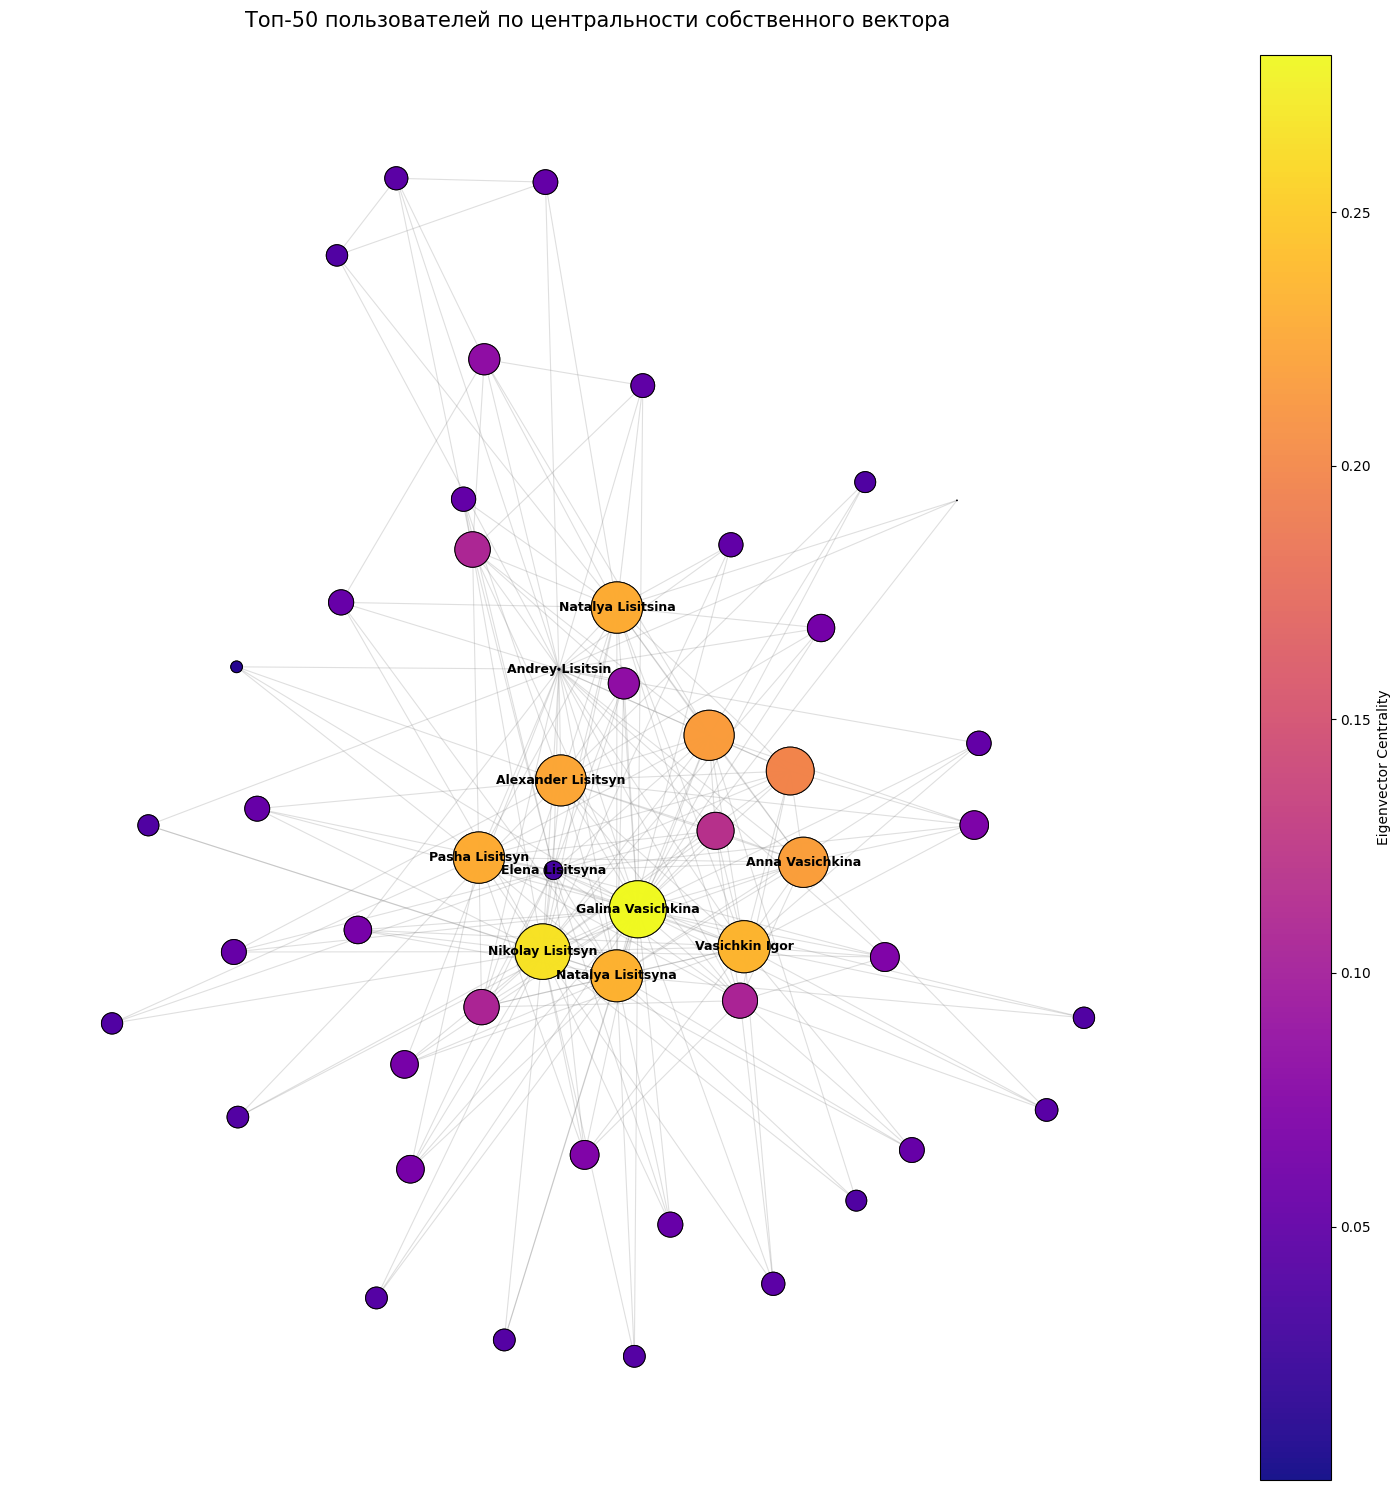

In [58]:
eigen_dict = {index_to_name[i]: centrality[i] for i in range(n)}

top_n = 50
top_indices = np.argsort(-centrality)[:top_n]
top_nodes = [index_to_name[i] for i in top_indices]
H = G.subgraph(top_nodes)

pos = nx.spring_layout(H, seed=42, k=0.45, iterations=100)

node_sizes = [6000 * eigen_dict[n] for n in H.nodes()]
node_colors = [eigen_dict[n] for n in H.nodes()]

plt.figure(figsize=(15, 15))

nx.draw_networkx_edges(H, pos, alpha=0.25, edge_color='gray', width=0.8)

nx.draw_networkx_nodes(
    H, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.plasma,
    alpha=0.95,
    edgecolors='black',
    linewidths=0.7
)

top_labels = set([index_to_name[i] for i in top_indices[:10]])
labels = {n: n for n in H.nodes() if n in top_labels}
nx.draw_networkx_labels(H, pos, labels, font_size=9, font_weight='bold')

nodes = nx.draw_networkx_nodes(
    H, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.plasma,
    alpha=0.95,
    edgecolors='black',
    linewidths=0.7
)

plt.colorbar(nodes, label='Eigenvector Centrality')

plt.title("Топ-50 пользователей по центральности собственного вектора", fontsize=15, pad=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("./results/graph_top50_eigen.png", format='png', dpi=300)
plt.show()

Граф для пользователей по центральности собственного вектора и близости

In [ ]:
closeness_dict = {index_to_name[i]: closeness[i] for i in range(n)}

plt.figure(figsize=(15, 15))

nx.draw_networkx_edges(H, pos, alpha=0.25, edge_color='gray', width=0.7)

nx.draw_networkx_nodes(
    H, pos,
    node_size=[4000 * eigen_dict[n] / max(eigen_dict.values()) for n in H.nodes()],
    node_color=[closeness_dict[n] for n in H.nodes()],
    cmap=plt.cm.plasma,
    alpha=0.95,
    edgecolors='black',
    linewidths=0.5
)

labels = {n: n for n in H.nodes() if n in top_labels}
nx.draw_networkx_labels(H, pos, labels, font_size=9, font_weight='bold')

nodes = nx.draw_networkx_nodes(
    H, pos,
    node_size=[4000 * eigen_dict[n] / max(eigen_dict.values()) for n in H.nodes()],
    node_color=[closeness_dict[n] for n in H.nodes()],
    cmap=plt.cm.plasma,
    alpha=0.95,
    edgecolors='black',
    linewidths=0.5
)

plt.colorbar(nodes, label='Closeness Centrality')

plt.title("Топ-50 пользователей: размер — Eigenvector Centrality, цвет — Closeness Centrality", fontsize=15, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()